In [1]:
%matplotlib inline 

import numpy as np
import scipy
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
from mpl_toolkits.mplot3d import Axes3D #3D plotting
import datetime as dt # module for manipulating dates and times

import requests 
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import binom
from scipy.optimize import minimize_scalar
from __future__ import division
import re
from StringIO import StringIO
from zipfile import ZipFile 
from pandas import read_csv
from urllib import urlopen
import urllib2
import json

import sklearn
import sklearn.preprocessing
import sklearn.datasets

# Gaussian Shocks

### LMSR ACCORDING TO Brahma et al.

In [2]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def runlmsr_gaussian(iterations, trialnumber, MMb, traderAlphaExponential, shock_prob, shock_sd):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        
        difference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            initialvalue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse

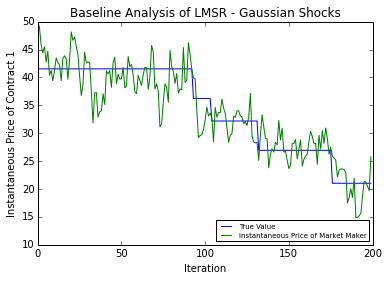

522.391671902
4142.76638979
-7720.09262177


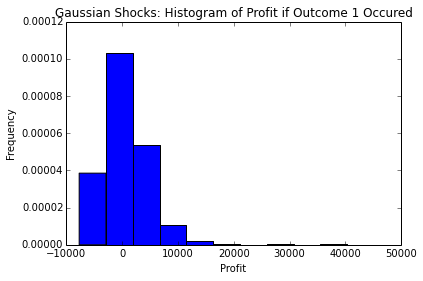

666.488712522
4055.47684634
-8413.17168148


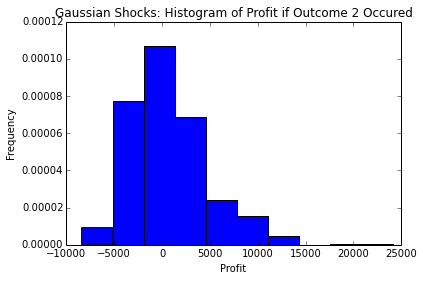

3.68492742044


In [3]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1, rmse = runlmsr_gaussian(200, 1000, 125, 20, 1/100, 5)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LMSR - Gaussian Shocks')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))

plt.hist(trial_1, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Gaussian Shocks: Histogram of Profit if Outcome 1 Occured')
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Gaussian Shocks: Histogram of Profit if Outcome 2 Occured')
plt.show()

print(np.mean(rmse))

In [25]:
beta = [10, 125, 250,500]

for betaspecific in beta:
    # Baseline Revenue Results 
    trial_1, trial_2, trueValue, MMprice_1, rmse = runlmsr_gaussian(200, 1000, betaspecific, 20, 1/100, 5)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.average(trial_2))
    print(np.std(trial_2))
    print(np.min(trial_2))
    print(np.mean(rmse))

58.8876402676
339.993363784
-692.737041902
46.7988201441
399.629093968
-659.923963072
4.79646865719
546.28989409
4232.00939582
-7938.08580004
695.57310219
4197.55411566
-8206.39850288
3.6665702941
1341.88848619
8282.54222691
-15964.6069484
945.765825716
7840.98471866
-15975.0413928
3.25320087358
2896.35008599
17101.9463954
-28625.8402053
1758.3155746
15354.3445412
-33023.2550544
3.10779131382


### Liquidity Sensitive LMSR Implementation Das Interpretation


In [2]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_gaussian(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0
        
        difference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            initialValue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            if MMprice_1[time]>100 or MMprice_2[time]>100:
                MMquantity_1[time] = 0
                MMquantity_2[time] = 0
                MMprice_1[time] = MMprice_1[time-1]
                MMprice_2[time] = MMprice_1[time-1]
                MMpayment[time] = 0
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse

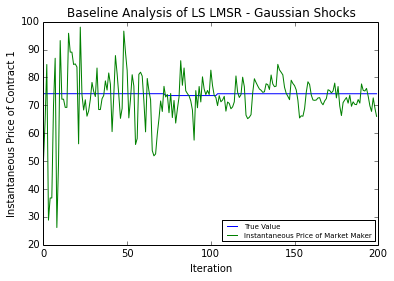

-6447.41855486
7197.3972729
-19928.1905076


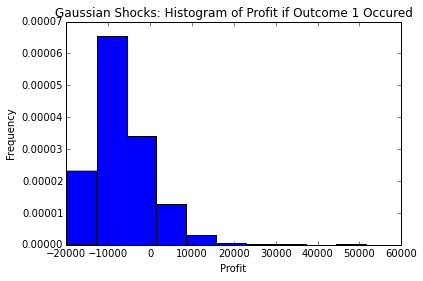

-9304.90358874
5648.34339362
-19172.117668


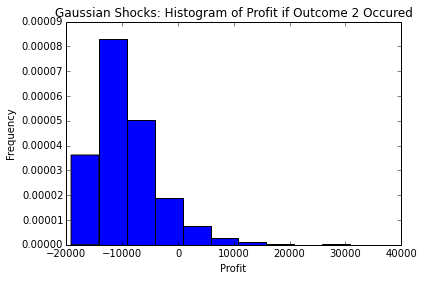

10.7165725185


In [3]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1, rmse = runlslmsr_gaussian(200, 1000, 20, 1/100, 5, 0.05, 100)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LS LMSR - Gaussian Shocks')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))

plt.hist(trial_1, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Gaussian Shocks: Histogram of Profit if Outcome 1 Occured')
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Gaussian Shocks: Histogram of Profit if Outcome 2 Occured')
plt.show()

print(np.mean(rmse))

In [4]:
alpha = [0.02, 0.05, 0.1, 0.2]

for alphaspecific in alpha:
    # Baseline Revenue Results 
    trial_1, trial_2, trueValue, MMprice_1, rmse = runlslmsr_gaussian(200, 1000, 20, 1/100, 5, alphaspecific, 10)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.average(trial_2))
    print(np.std(trial_2))
    print(np.min(trial_2))
    print(np.mean(rmse))

-952.95994751
96.6783843826
-1116.7567871
-968.115304172
85.4926558644
-1164.21763417
26.6636621336
757.624393167
3108.98653356
-5458.75921322
-290.65052659
2818.58220376
-5433.43156195
19.7227713286
5128.51956624
9014.49731915
-12620.078813
-1770.79362214
6821.12374461
-13191.8293885
12.5859483877
21474.778411
19596.0693055
-26832.8543227
-9429.10704169
9547.56444637
-29342.7006835
9.45011084927


In [5]:
initial = [10,20,50,100]

for initialspecific in initial:
    # Baseline Revenue Results 
    trial_1, trial_2, trueValue, MMprice_1, rmse = runlslmsr_gaussian(200, 1000, 20, 1/100, 5, 0.05, initialspecific)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.average(trial_2))
    print(np.std(trial_2))
    print(np.min(trial_2))
    print(np.mean(rmse))

682.546452527
2948.61950006
-5474.14924375
-390.833595086
2517.89958107
-5995.9756037
19.6692779153
744.684436784
5133.86604171
-8511.39060264
-1150.31309762
4297.01760554
-8748.86321545
15.9358478431
-1654.36795505
6532.46231173
-12572.2098943
-4101.18398335
5620.00099012
-12891.4195473
12.6211932517
-6205.90288526
7219.1144333
-18729.6801242
-9444.85428623
5583.10209262
-18214.856962
10.6694324255


## Uniform Shock

In [9]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def runlmsr_uniform(iterations, trialnumber, MMb, traderAlphaExponential):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        
        difference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            initialvalue = trueValue[time-1]
            if time == iterations/2:
                initialValue = initialValue + np.random.uniform(0, 40)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse

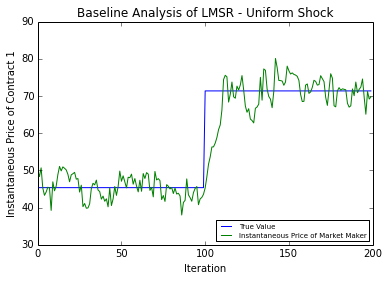

-3669.82328744
3267.41743653
-8663.0896945


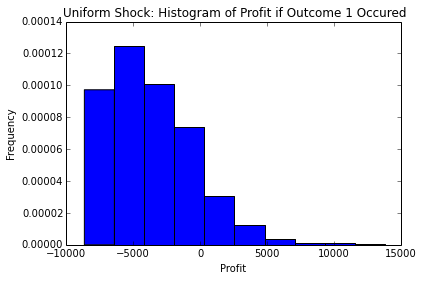

10696.1904589
17775.2398349
-6390.36231145


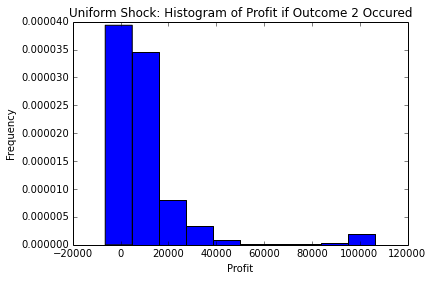

4.42164300807


In [7]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1, rmse = runlmsr_uniform(200, 1000, 125, 20)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LMSR - Uniform Shock')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))

plt.hist(trial_1, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Uniform Shock: Histogram of Profit if Outcome 1 Occured')
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Uniform Shock: Histogram of Profit if Outcome 2 Occured')
plt.show()

print(np.mean(rmse))

In [11]:
beta = [10, 125, 250,500]

for betaspecific in beta:
    # Baseline Revenue Results 
    trial_1, trial_2, trueValue, MMprice_1, rmse = runlmsr_uniform(200, 1000, betaspecific, 20)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.average(trial_2))
    print(np.std(trial_2))
    print(np.min(trial_2))
    print(np.mean(rmse))

-289.338310263
268.024377577
-693.04717556
879.298430113
1486.25452085
-455.995608673
4.82490883482
-3638.85759093
3415.00017221
-8663.0896945
11359.6961521
19360.1710802
-5496.48230051
4.47396637543
-7515.22086092
6684.1169674
-17326.179389
22388.1314482
35283.8700801
-13180.8623422
4.74172624869
-15333.5695164
12936.1425327
-34530.8666539
38195.6988769
44466.3303786
-26731.3058096
5.73996458788


In [6]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_uniform(iterations, trialnumber, traderAlphaExponential, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        difference = np.zeros(iterations)
        
        for time in np.arange(1,iterations,1):
            initialValue = trueValue[time-1]
            if time == iterations/2:
                initialValue = initialValue + np.random.uniform(0, 40)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            if MMprice_1[time]>100 or MMprice_2[time]>100:
                MMquantity_1[time] = 0
                MMquantity_2[time] = 0
                MMprice_1[time] = MMprice_1[time-1]
                MMprice_2[time] = MMprice_1[time-1]
                MMpayment[time] = 0
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse

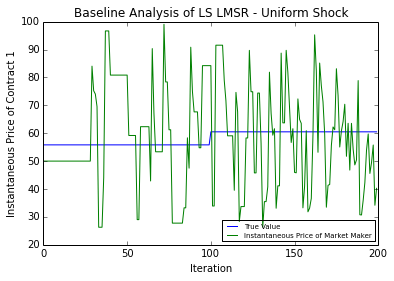

-1672.76274902
2175.79026215
-6791.42896591


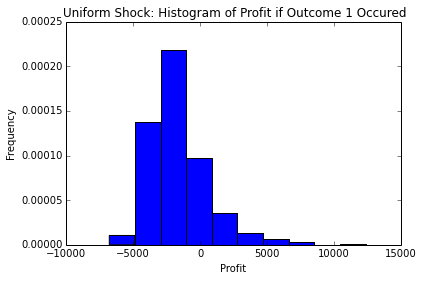

3722.78316768
5247.27422745
-5873.71799731


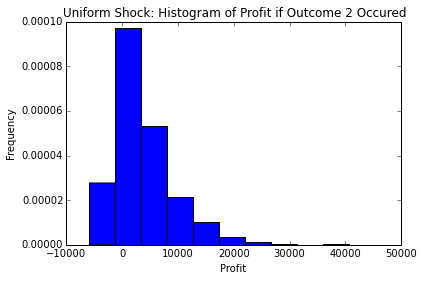

19.3711543436


In [7]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1,rmse = runlslmsr_uniform(200, 1000, 20, 0.05, 10)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LS LMSR - Uniform Shock')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))

plt.hist(trial_1, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Uniform Shock: Histogram of Profit if Outcome 1 Occured')
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Uniform Shock: Histogram of Profit if Outcome 2 Occured')
plt.show()

print(np.mean(rmse))

In [8]:
alpha = [0.02, 0.05, 0.1, 0.2]

for alphaspecific in alpha:
    # Baseline Revenue Results 
    trial_1, trial_2, trueValue, MMprice_1, rmse = runlslmsr_uniform(200, 1000, 20, alphaspecific, 10)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.average(trial_2))
    print(np.std(trial_2))
    print(np.min(trial_2))
    print(np.mean(rmse))

-982.787246306
81.341568745
-1163.91251341
-930.713063659
114.38680206
-1175.72544613
27.1111936034
-1670.3551654
2159.7616115
-6001.73402975
3694.02662207
5174.6690539
-4439.23105577
19.4368859433
-3923.95869128
6517.05651287
-16120.0091577
12597.1834223
16738.9288131
-10459.2638161
12.6996969693
-2858.2418677
16810.042927
-38015.2973862
16963.3452422
32913.8398095
-19805.6427574
9.93016198262


In [9]:
initial = [10,20,50,100]

for initialspecific in initial:
    # Baseline Revenue Results 
    trial_1, trial_2, trueValue, MMprice_1, rmse = runlslmsr_uniform(200, 1000,20, 0.05, initialspecific)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.average(trial_2))
    print(np.std(trial_2))
    print(np.min(trial_2))
    print(np.mean(rmse))

-1599.99579011
2085.54087242
-5803.6509625
3553.82398809
5373.66061692
-4702.23519795
19.5534065759
-3480.59060016
3316.53820917
-9121.71230288
7129.7544172
10307.8452441
-6925.67536516
15.8401354974
-7421.22738763
4380.20612558
-13596.8219952
7599.21958848
14723.9052617
-11628.398689
12.6860938551
-12836.0422178
4808.35624489
-19799.7114609
3292.77028899
15844.2772588
-16474.0185731
10.9061192304


## Our LMSR model

### LMSR TEXTBOOK

In [4]:
# LMSR Implementation Textbook Interpretation
def runlmsr_gaussiantextbook(iterations, trialnumber, MMb, traderAlphaExponential, shock_prob, shockSD):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = 0
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = 0
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            initialvalue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityTrader_1 < 0 and traderValue<90.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2, quantityTrader_1
                    raise NameError('Problem with Quantity Calculation')
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityTrader_2 < 0 and traderValue<90.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2, quantityTrader_2
                    raise NameError('Problem with Quantity Calculation')
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1


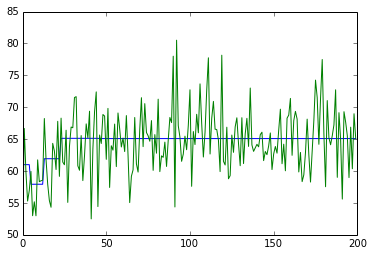

797.336224597
5359.30468355
-8663.0896945


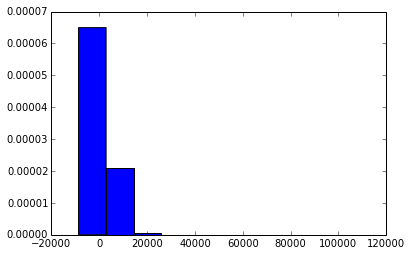

705.597238106
6287.47781319
-8663.0896945


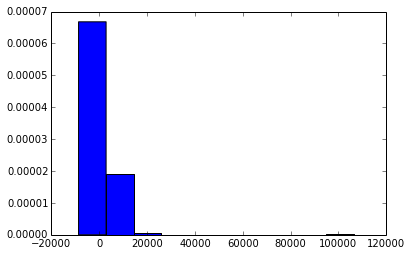

In [5]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlmsr_gaussiantextbook(200, 1000, 125, 20, 1/100, 5)
# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


### Liquidity sensitive - trying an optimzer to solve for myopic trader

In [40]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_gaussianmyopic(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)

    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            initialValue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                f = lambda q: (alpha*np.log(np.exp(q/MMb) + \
                                           np.exp(currentquantity_2/MMb)) + (currentquantity_2*(np.exp(q/MMb) - \
                                           np.exp(currentquantity_2/MMb))) / ((q+currentquantity_2)*(np.exp(q/MMb) + \
                                           np.exp(currentquantity_2/MMb)))) - traderValue 
                res = minimize_scalar(f, method='brent')
                if res.x > 0 and res.success == 1:
                    quantityTrader_1 = min(quantityTrader, res.x)
                else:
                    quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                f = lambda q: (alpha*np.log(np.exp(q/MMb) + \
                                           np.exp(currentquantity_1/MMb)) + (currentquantity_1*(np.exp(q/MMb) - \
                                           np.exp(currentquantity_1/MMb))) / ((q+currentquantity_1)*(np.exp(q/MMb) + \
                                           np.exp(currentquantity_1/MMb)))) - traderValue 
                res = minimize_scalar(f, method='brent', options={'xtol': 0.001})
                if res.x > 0 and res.success == 1:
                    quantityTrader_2 = min(quantityTrader, res.x)
                else:
                    quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1   
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            if MMprice_1[time]>100 or MMprice_2[time]>100:
                MMquantity_1[time] = 0
                MMquantity_2[time] = 0
                MMprice_1[time] = MMprice_1[time-1]
                MMprice_2[time] = MMprice_1[time-1]
                MMpayment[time] = 0
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1

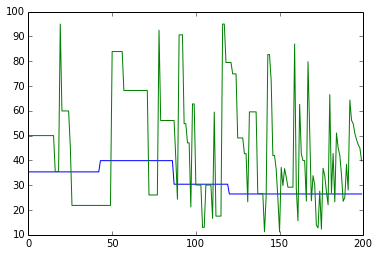

666.081914163
2981.16843792
-5013.58500636


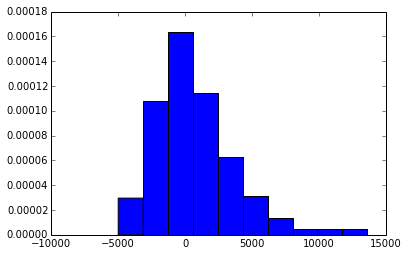

-303.282030056
2759.01346423
-5614.01391009


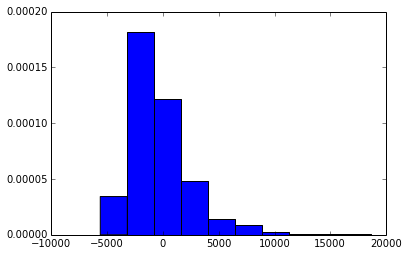

In [41]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlslmsr_gaussianmyopic(200, 1000, 20, 1/100, 5, 0.05, 10)
# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


## COMBINATION (RUNNING LMSR AT SAME TIME AS LS LMSR)

In [11]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def bothlmsr_gaussian(iterations, trialnumber, typMMb, traderAlphaExponential, shock_prob, shock_sd):
    typtrial_1 = np.zeros(trialnumber)
    typtrial_2 = np.zeros(trialnumber)
    typrmse = np.zeros(trialnumber)
    lstrial_1 = np.zeros(trialnumber)
    lstrial_2 = np.zeros(trialnumber)
    lsrmse = np.zeros(trialnumber)
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        typeMMquantity_1 = np.zeros(iterations)
        typMMprice_1 = np.zeros(iterations)
        typMMprice_1[0] = 50
        lsMMquantity_1 = np.zeros(iterations)
        lsMMprice_1 = np.zeros(iterations)
        lsMMprice_1[0] = 50
        
        #outcome 2
        typMMquantity_2 = np.zeros(iterations)
        typMMprice_2 = np.zeros(iterations)
        typMMprice_2[0] = 50
        lsMMquantity_2 = np.zeros(iterations)
        lsMMprice_2 = np.zeros(iterations)
        lsMMprice_2[0] = 50
        
        #revenue
        typMMpayment = np.zeros(iterations)
        lsMMpayment = np.zeros(iterations)
        
        typdifference = np.zeros(iterations)
        lsdifference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            
            # STANDARD LMSR 
            currentquantity_1 = np.sum(typMMquantity_1)
            currentquantity_2 = np.sum(typMMquantity_2)
            MMb = typMMb
            
            if traderValue > typMMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, typMMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                typMMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, typMMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                typMMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            typMMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            typMMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            typMMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            typdifference[time] = (typMMprice_1[time] - trueValue[time]) ** 2
            
            # LIQUID SENSITIVE LMSR
            currentquantity_1 = np.sum(lsMMquantity_1)
            currentquantity_2 = np.sum(lsMMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            if traderValue > lsMMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                lsMMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = quantityTrader
                lsMMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            lsMMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            lsMMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            lsMMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            lsdifference[time] = (lsMMprice_1[time] - trueValue[time]) ** 2
        typtrial_1[i] = np.sum(typMMpayment)-100*np.sum(typMMquantity_1)
        typtrial_2[i] = np.sum(typMMpayment)-100*np.sum(typMMquantity_2)
        typrmse[i] = np.sqrt(np.sum(typdifference)/iterations)        
        lstrial_1[i] = np.sum(lsMMpayment)-100*np.sum(lsMMquantity_1)
        lstrial_2[i] = np.sum(lsMMpayment)-100*np.sum(lsMMquantity_2)
        lsrmse[i] = np.sqrt(np.sum(lsdifference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse